In [12]:
# Basic
import numpy as np
from matplotlib import pyplot as plt

# For Dataset
from collections import deque, namedtuple
import random

# For solvers
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp
from casadi import *

# For estimators
from torch import nn
import torch
import torch.nn.functional as F


## AAC system

In [2]:
class AAC:
    def __init__(self, m, c_d, f0, f1, f2, v_ego):
        self.m = m
        self.c_d = c_d
        self.f0 = f0
        self.f1 = f1
        self.f2 = f2
        self.v_ego = v_ego
        self.u = 0
        
        
    def update(self, x0, u, t, dt):
        
        x = MX.sym('x',3) # Three states
        
        p = x[0]
        v = x[1]
        z = x[2]
        
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        
        f = vertcat(
            v,
            -1/self.m*Fr,
            self.v_ego - v           
        )
        g = vertcat([
            0,
            1/self.m *u,
            0
        ])
        

        dx = f + g
        
        ode = {}         # ODE declaration
        ode['x']   = x   # states
        ode['ode'] = dx # right-hand side 

        # Construct a Function that integrates over 4s
        F = integrator('F','cvodes',ode,{'t0':t,'tf':t+dt})

        res = F(x0=x0)
        
        x_n = res['xf'].elements()
        
        return x_n 
        
        

## Controller

In [3]:
class LQPCBFCLF:
    def __init__(self, m_nom, ca_nom, cd_nom, f0_nom, f1_nom, f2_nom, v_ego_nom, v_des, Th, clf_rate, cbf_rate, p_slack):
        self.m = m_nom
        self.ca = ca_nom
        self.cd = cd_nom
        self.f0 = f0_nom
        self.f1 = f1_nom
        self.f2 = f2_nom
        self.v_ego = v_ego_nom 
        self.v_des = v_des
        self.Th = Th
        
        self.p_slack = p_slack
        self.cbf_rate = cbf_rate
        self.clf_rate = clf_rate
        
        
    def clf(self, symb_x):
        v = symb_x[1]        

        clf = (v - self.v_des)**2;
        return clf
        
    def cbf(self, symb_x):
        v = symb_x[1]
        z = symb_x[2]

        cbf = z - self.Th * v - 0.5  * (self.v_ego - v)**2 / (self.cd * 9.81);
        return cbf
        

    def dcbf(self, x, u):
        v = x[1]
        z = x[2]
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2

        dB = 1/self.m * (self.Th + (v - self.v_ego)/self.cd/9.81 ) * (Fr - u) + (self.v_ego - v)
        
        return dB
        
    def compute_controller(self, x, u_ref, A_h, B_h, weights):
        v = x[1]
        z = x[2]

        u = SX.sym('u')
        slack = SX.sym('slack')
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        
        V = self.clf(x)
        dV = (v - self.v_des)*(2/self.m*(u - u_ref))

        B = self.cbf(x);
        dB = 1/self.m * (self.Th + (v - self.v_ego)/self.cd/9.81 ) * (Fr - u) + (self.v_ego - v)
        
        
        
        a_h = A_h.forward(x)
        b_h = B_h.forward(x)
        
        S = dB + a_h + b_h * u
        
        weight_input = 2/self.m**2
        
        fqp = (u_ref - u)**2 * weight_input + self.p_slack * slack**2
        gqp = vertcat( -dV - self.clf_rate*V + slack, S + self.cbf_rate * B)
        
        # Optimization
        qp = {'x': vertcat(u,slack), 'f':fqp, 'g':gqp}
        
        
        S = nlpsol('S', 'ipopt', qp,{'verbose':False,'print_time':False, "ipopt": {"print_level": 0}})

        r = S(lbg=0, lbx = -m*self.cd*g, ubx = m*self.ca*g)
        
        k = r['x'].elements()[0]
        slack_sol = r['x'].elements()[1]
        #dasdasd
        
        return a_h, b_h, k, slack_sol, V, B, dB

## Dataset

In [4]:


Transition = namedtuple('Transition',
                        ('x', 'k', 'dh', 'dh_hat'))


class Dataset:
    def __init__(self):
        #self.capacity = capacity 
        self.D = deque()
        
    def reset(self):
        self.D = deque()
    
    def update(self, *args):
        self.D.append(Transition(*args))
        
    def get_D(self):
        sample = Transition(*zip(*self.D))
        return sample
        
    

## Estimator

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.fill_(0.0)
        m.bias.data.fill_(0.0)

class Estimator:
    def __init__(self, input_size, output_size = 1):
        f1 = 50
        f2 = 50
        
        self.model = nn.Sequential(
                                  nn.Linear(input_size, f1),                   nn.Sigmoid(),
                                  nn.Linear(f1, f2),                           nn.Sigmoid(),
                                  nn.Linear(f2, output_size)
                                )
        
        self.model.apply(weights_init)
        
    def forward(self, x, train = False):
        x = torch.from_numpy(np.array(x)).float()
        #print(x)
        z = self.model(x)
        
        if not train:
            z = z.detach().float().item()
            
        return z

## Utils

In [9]:
def sample_initial_state(p_min = 0, p_max = 2,
                         v_min = 18, v_max = 22,
                         z_min = 38, z_max = 42):
    p0 = np.random.uniform(p_min, p_max)
    v0 = np.random.uniform(v_min, v_max)
    z0 = np.random.uniform(z_min, z_max)
    return [p0, v0, z0] # [0,20,40]##

class Derivator:
    def __init__(self, dt):
        self.x = 0
        self.dt = dt
        
    def update(self, x_n):
        dx = (x_n - self.x)/dt
        
        self.x = x_n
        
        
        return dx
    

# Parameters

In [6]:
dt = 0.02
simTime = 10

# Real parameters
v_ego = 22
v_des = 24
m  = 1650.0
g = 9.81

# 
f0 = 0.1
f1 = 5
f2 = 0.25
#

c_a = 0.3
c_d = 0.3
Th = 1.8

# Nominal parameters
f0_nom = 10*f0
f1_nom = 10*f1
f2_nom = 10*f2

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Initial state
p0 = 0
v0 = 20
z0 = 40

x = [p0, v0 ,z0]

x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []


In [7]:
class PID:
    def __init__(self, x_dim, u_dim, Kp, Kd, Ki, dT):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        
        self.dT = dT
        
        self.e = np.zeros([x_dim,1])
        self.de = np.zeros([x_dim,1])
        self.ei = np.zeros([x_dim,1])
        
        # e(t-1) 
        self.e_1 = np.zeros([x_dim,1])
        
    def update(self, e):
        self.e = e
        
        # Compute derivative
        self.de = (self.e - self.e_1)/self.dT
        
        # Compute integral
        self.ei =  self.ei + self.dT*(self.e - self.e_1)/2
        
        u = self.Kp.dot(self.e) + self.Kd.dot(self.de)  + self.Ki.dot(self.ei)
        
        self.e_1 = self.e
        
        return u
        

    def reset(self):
        self.e = np.zeros([x_dim,1])
        self.de = np.zeros([x_dim,1])
        self.ei = np.zeros([x_dim,1])
        
        # e(t-1) 
        self.e_1 = np.zeros([x_dim,1])
        
        
        

## Main

In [10]:
d = Dataset()
T = 10   # Number of experiences

aac = AAC(m, c_d, f0, f1, f2, v_ego)

cont = LQPCBFCLF(0.8*m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)

A_h = Estimator(3)
A_h_opt = torch.optim.Adam(A_h.model.parameters(), lr = 1e-6)

B_h = Estimator(3)
B_h_opt = torch.optim.Adam(B_h.model.parameters(), lr = 1e-6)


weights = 0.2

x_lst = []
u_lst = []
V_lst = []
B_lst = []
B_perf_lst = []
slack_lst = []


a_h_lst = []
b_h_lst = []

# PID control reference
x_dim = 3
u_dim = 1

kp = np.array([[0, 1.0e3, 0]])
kd = np.array([[0, 0.1, 0]])
ki = np.array([[0, 1.0e3, 0]])

pid = PID(x_dim, u_dim, kp, kd, ki, dt)



for _ in range(T):
    x0 = sample_initial_state()
    x = x0
    derivator = Derivator(dt)
    
    xs = []
    us = []
    Vs = []
    Bs = []
    B_perfs = []
    slacks = []
    b_hs = []
    a_hs = []
    
    pid.reset()
    
    for t in np.arange(0, simTime, dt): #simTime
        # Get Fr
        v = x[1]
        Fr = f0_nom * v**2 + f1_nom * v + f2_nom
        
        # Get reference control
        e = np.array([[0], [v_des], [0]]) - np.expand_dims(x, axis = 1)
        u_ref = pid.update(e) #f0_nom * v**2 + f1_nom * v + f2_nom
        u_ref = u_ref[0,0]
        
        aac.v_ego = v_ego + 5*np.sin(2*t) # lead_vehicle
        cont.v_ego =  v_ego + 5*np.sin(2*t)

        # Control Input
        a_h, b_h, k, slack_sol, V, B, db_hat = cont.compute_controller(x, u_ref, A_h, B_h, weights)
        
        B_perf = x[2] - Th * x[1] - 0.5  * (v_ego - x[1])**2 / (c_d * 9.81)

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
        
        db = derivator.update(B)
        
        d.update(x, k, db, db_hat)
        
        xs.append(x)
        us.append(k)
        Vs.append(V)
        Bs.append(B)
        slacks.append(slack_sol)
        a_hs.append(a_h)
        b_hs.append(b_h)
        B_perfs.append(B_perf)
        
        # Train estimator
        sample = d.get_D()

        for x_i, k_i, dh_i, dh_hat_i in zip(sample.x[-1:], sample.k[-1:], sample.dh[-1:], sample.dh_hat[-1:] ):
            S_i = A_h.forward(x_i, train = True) + B_h.forward(x_i, train = True)*k_i + cont.dcbf(x_i, k_i) #dh_hat_i 
            Loss = F.mse_loss(torch.tensor(dh_i),S_i)

            A_h.model.zero_grad()
            B_h.model.zero_grad()

            Loss.backward()
            A_h_opt.step()
            B_h_opt.step()

        x = x_n
        
        
    # Save data
    x_lst.append(xs)
    u_lst.append(us)
    V_lst.append(Vs)
    B_lst.append(Bs)
    slack_lst.append(slacks)
    a_h_lst.append(a_hs)
    b_h_lst.append(b_hs)
    B_perf_lst.append(B_perfs)


    
        
        



((0.00118211*(1520.71-u))+0.70518)

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



/home/emanuelsamir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


((0.00114342*(1525.31-u))+0.855502)
((0.00110423*(1529.7-u))+1.00775)
((0.00106441*(1533.82-u))+1.16241)
((0.00102392*(1537.6-u))+1.31973)
((0.000982701*(1541.01-u))+1.47984)
((0.000940738*(1544-u))+1.64286)
((0.000898005*(1546.54-u))+1.80887)
((0.000854476*(1548.58-u))+1.97797)
((0.000810122*(1550.09-u))+2.15027)
((0.000764905*(1551.03-u))+2.32593)
((0.000718771*(1551.35-u))+2.50515)
((0.000671643*(1550.99-u))+2.68823)
((0.000623408*(1549.88-u))+2.87561)
((0.000573896*(1547.94-u))+3.06795)
((0.000522846*(1545.05-u))+3.26627)
((0.000469838*(1541.03-u))+3.47219)
((0.000414172*(1535.62-u))+3.68844)
((0.000359169*(1529.98-u))+3.90212)
((0.000305524*(1524.35-u))+4.11051)
((0.0002533*(1518.73-u))+4.31339)
((0.000202555*(1513.11-u))+4.51052)
((0.000153345*(1507.51-u))+4.70169)
((0.000105724*(1501.91-u))+4.88669)
((9.00437e-05*(1507.17-u))+4.9476)
((7.60487e-05*(1512.44-u))+5.00197)
((6.37847e-05*(1517.71-u))+5.04961)
((5.32948e-05*(1522.99-u))+5.09036)
((4.46192e-05*(1528.27-u))+5.12407)
((3

### No training

Text(0.5, 1.0, 'CLF')

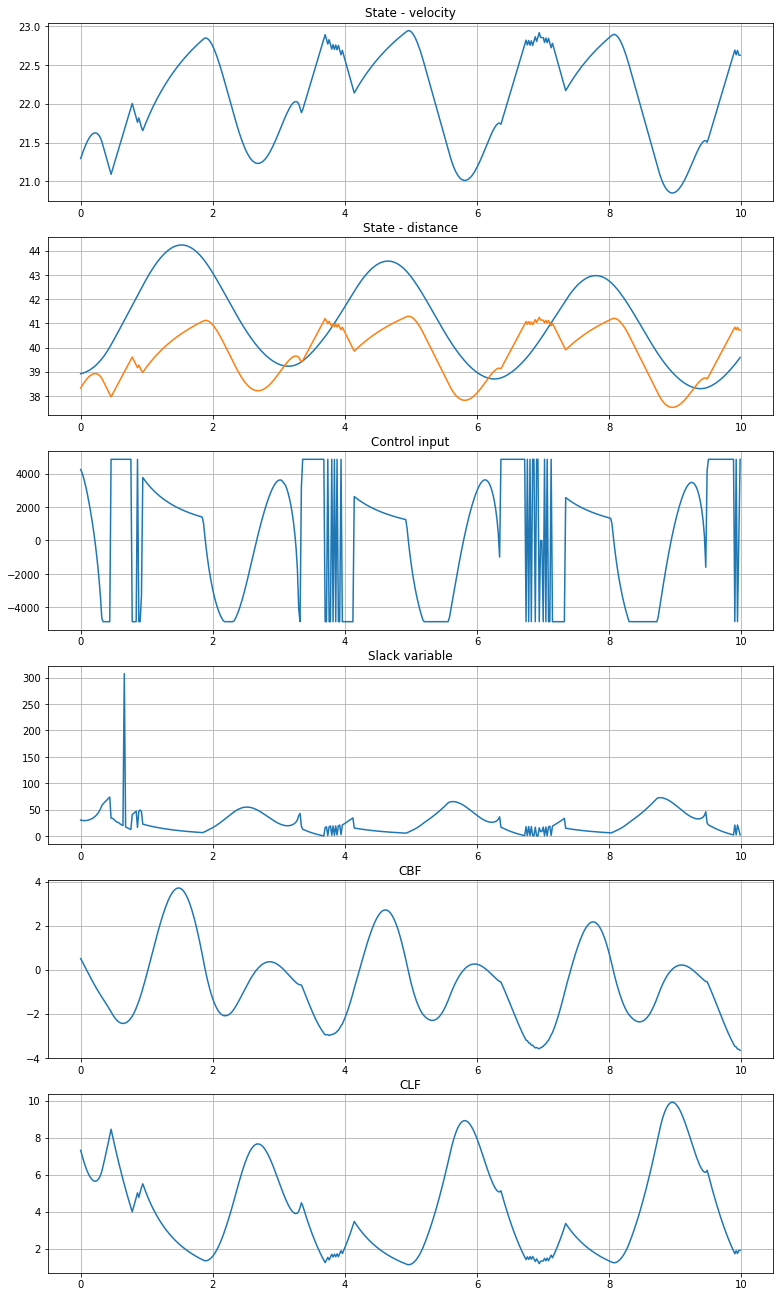

In [11]:
f,ax = plt.subplots(6,1,figsize = (13,23))
t_lns = np.arange(0, 10, dt)
exp = 0


ax[0].plot(t_lns, np.array(x_lst)[exp,:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns, np.array(x_lst)[exp,:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')

ax[1].plot(t_lns, Th*np.array(x_lst)[exp,:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns, np.array(u_lst)[exp,:])
ax[2].grid(True)
ax[2].set_title('Control input')

ax[3].plot(t_lns, np.array(slack_lst)[exp,:])
ax[3].grid(True)
ax[3].set_title('Slack variable')

ax[4].plot(t_lns, np.array(B_lst)[exp,:])
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, np.array(V_lst)[exp,:])
ax[5].grid(True)
ax[5].set_title('CLF')


(500,)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

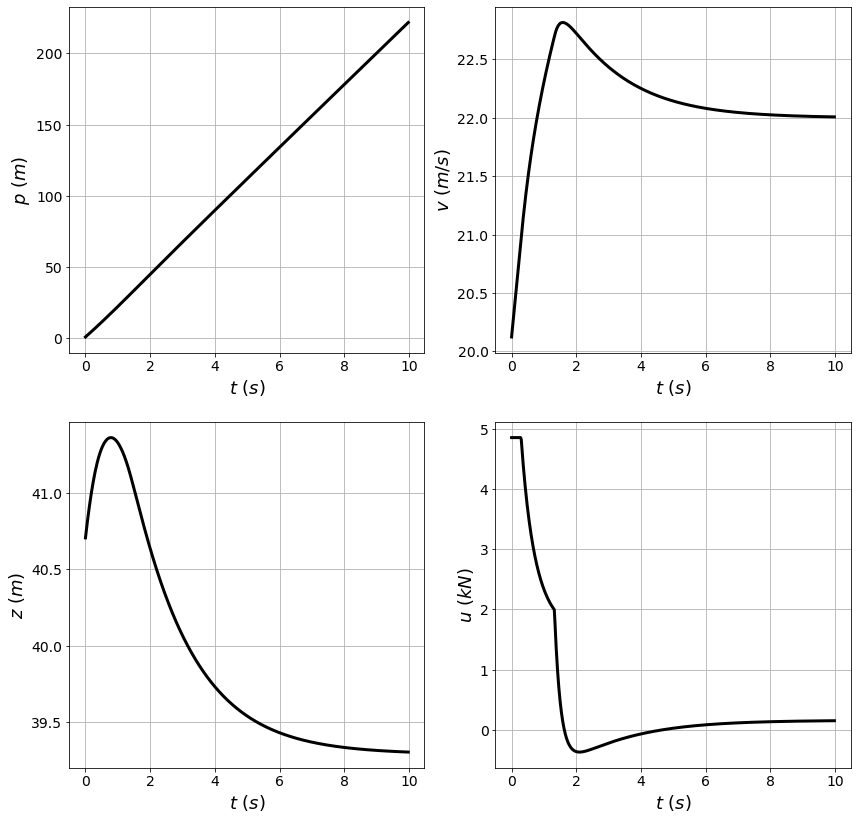

In [100]:
f,ax = plt.subplots(2,2,figsize = (14,14))
t_lns = np.arange(0, 10, dt)
exp = 9

ax[0,0].plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax[0,0].grid(True)
ax[0,0].set_ylabel('$p$ $(m)$', fontsize = 18)
ax[0,0].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

ax[0,1].plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax[0,1].grid(True)
ax[0,1].set_ylabel('$v$ $(m/s)$', fontsize = 18)
ax[0,1].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,1].set_title('State - velocity')

ax[1,0].plot(t_lns, np.array(x_lst)[exp,:,2],'k', linewidth = 3)
ax[1,0].grid(True)
ax[1,0].set_ylabel('$z$ $(m)$', fontsize = 18)
ax[1,0].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[1,0].set_title('State - distance')

ax[1,1].plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax[1,1].grid(True)
ax[1,1].set_ylabel('$u$ $(kN)$', fontsize = 18)
ax[1,1].set_xlabel('$t$ $(s)$', fontsize = 18)
#ax[1,1].tick_params(fontsize=14)
plt.yticks(fontsize=14)
plt.setp(ax[0,0].get_xticklabels(), fontsize=14)
plt.setp(ax[0,0].get_yticklabels(), fontsize=14)

plt.setp(ax[0,1].get_xticklabels(), fontsize=14)
plt.setp(ax[0,1].get_yticklabels(), fontsize=14)

plt.setp(ax[1,0].get_xticklabels(), fontsize=14) 
plt.setp(ax[1,0].get_yticklabels(), fontsize=14)



plt.setp(ax[1,1].get_xticklabels(), fontsize=14)
plt.setp(ax[1,1].get_yticklabels(), fontsize=14)


#ax[1,1].set_title('State - distance')

(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

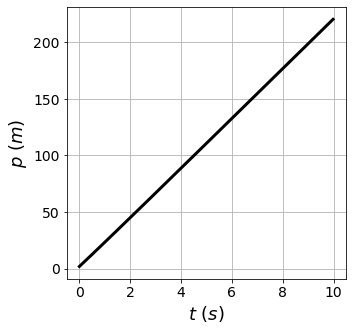

In [122]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 9

ax.plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$p$ $(m)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

(array([18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

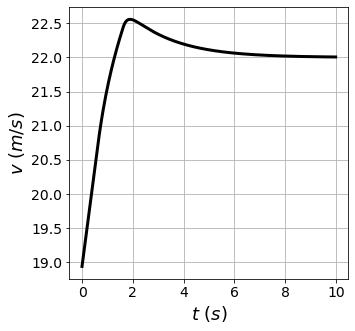

In [121]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$v$ $(m/s)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

(array([39.  , 39.25, 39.5 , 39.75, 40.  , 40.25, 40.5 , 40.75, 41.  ,
        41.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

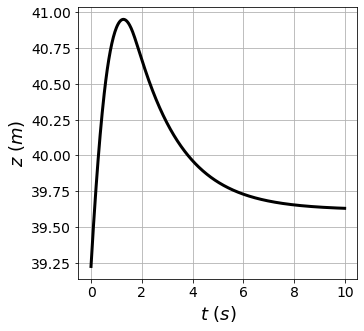

In [123]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(x_lst)[exp,:,2], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$z$ $(m)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

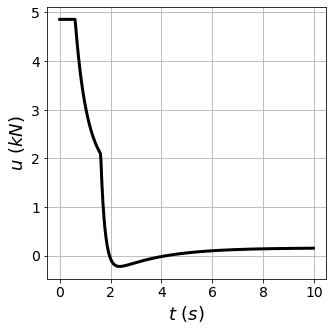

In [120]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$u$ $(kN)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

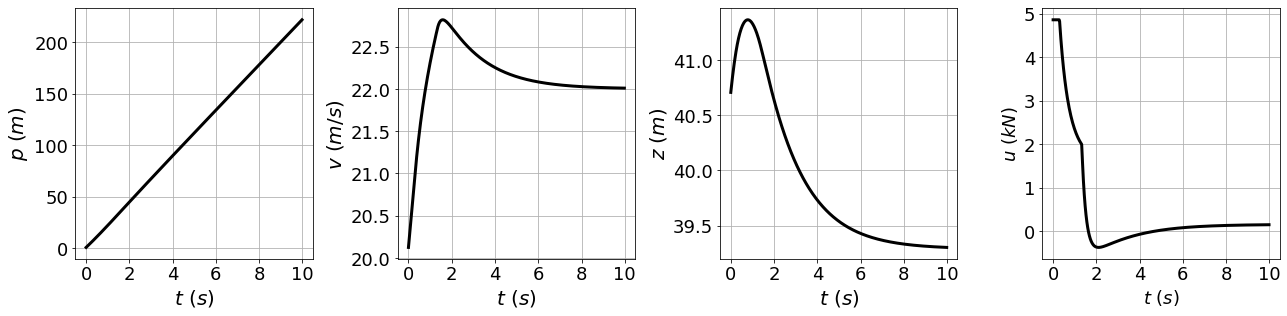

In [99]:
f,ax = plt.subplots(1,4,figsize = (18,4.5))
t_lns = np.arange(0, 10, dt)
exp = 0

ax[0].plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax[0].grid(True)
ax[0].set_ylabel('$p$ $(m)$', fontsize = 20)
ax[0].set_xlabel('$t$ $(s)$', fontsize = 20)

ax[1].plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax[1].grid(True)
ax[1].set_ylabel('$v$ $(m/s)$', fontsize = 20)
ax[1].set_xlabel('$t$ $(s)$', fontsize = 20)


ax[2].plot(t_lns, np.array(x_lst)[exp,:,2],'k', linewidth = 3)
ax[2].grid(True)
ax[2].set_ylabel('$z$ $(m)$', fontsize = 20)
ax[2].set_xlabel('$t$ $(s)$', fontsize = 20)

ax[3].plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax[3].grid(True)
ax[3].set_ylabel('$u$ $(kN)$', fontsize = 18)
ax[3].set_xlabel('$t$ $(s)$', fontsize = 18)



plt.setp(ax[0].get_xticklabels(), fontsize=18)
plt.setp(ax[0].get_yticklabels(), fontsize=18)

plt.setp(ax[1].get_xticklabels(), fontsize=18)
plt.setp(ax[1].get_yticklabels(), fontsize=18)

plt.setp(ax[2].get_xticklabels(), fontsize=18) 
plt.setp(ax[2].get_yticklabels(), fontsize=18)

plt.setp(ax[3].get_xticklabels(), fontsize=18)
plt.setp(ax[3].get_yticklabels(), fontsize=18)

f.tight_layout() 
#ax[1,1].set_title('State - distance')

### Barrier function

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

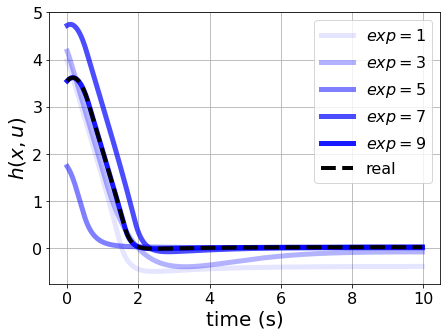

In [124]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0



for exp in range(10):
    if exp % 2 == 0:
        h = np.array(x_lst)[exp,start:,2] - Th*np.array(x_lst)[exp,start:,1]  - 0.5*(np.array(x_lst)[exp,start:,1] - v_ego)/c_d/g
        h = np.array(B_lst)[exp,start:]
        ax.plot(t_lns[start:], h , 'blue', alpha = 0.1 * (exp + 1), linewidth = 5)
        #print(exp)
        
h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'black',linewidth = 4, linestyle = '--')

ax.grid(True)
#ax.set_title('Barrier function evolution in multiple experiences', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 20)
ax.set_ylabel('$h(x, u)$', fontsize= 20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)



### Lyapunov function

Text(0, 0.5, '$V(x, u)$')

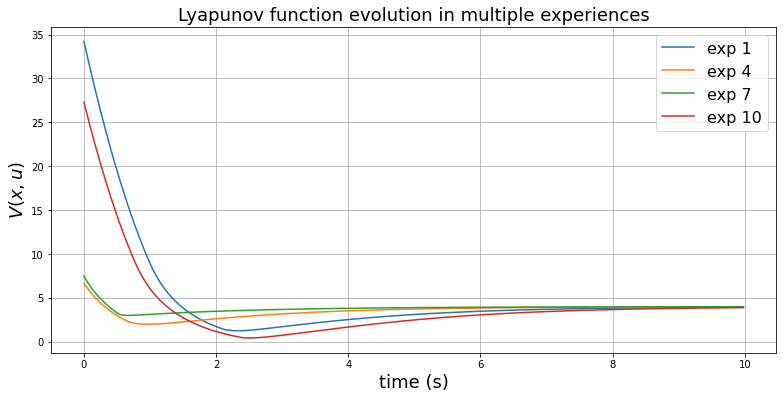

In [27]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 3 == 0:
        V = np.array(V_lst)[exp,start:]
        ax.plot(t_lns[start:], V )
        #print(exp)
        
ax.grid(True)
ax.set_title('Lyapunov function evolution in multiple experiences', fontsize= 18)
ax.legend(['exp 1','exp 4','exp 7','exp 10'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$V(x, u)$', fontsize= 18)

### Comparison with perfect knowledge

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

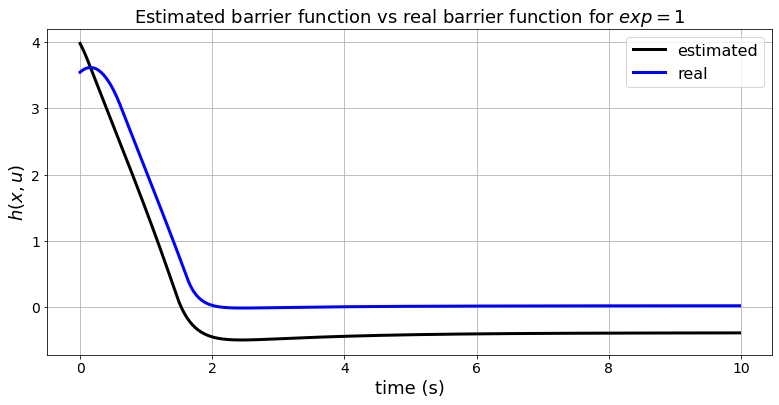

In [125]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 0

h_perf = np.array(B_perf_lst)[exp,start:]
ax.plot(t_lns[start:], h_perf, 'black',linewidth = 3 )

h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'blue',linewidth = 3)
#print(exp)
        
ax.grid(True)
ax.set_title('Estimated barrier function vs real barrier function for $exp = 1$', fontsize= 18)
ax.legend(['estimated','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$h(x, u)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

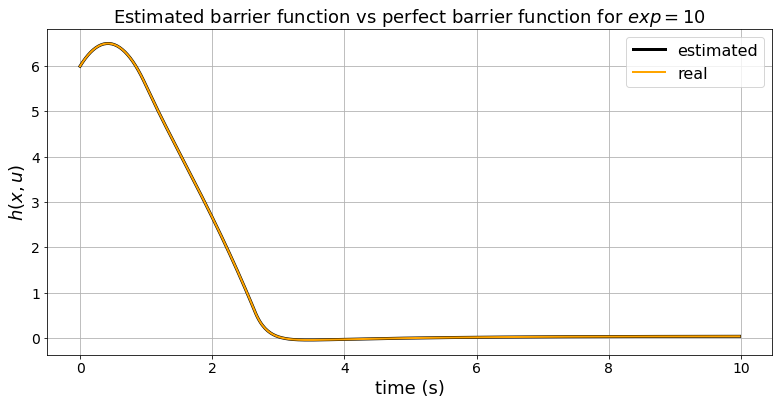

In [37]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 9

h_perf = np.array(B_perf_lst)[exp,start:]
ax.plot(t_lns[start:], h_perf, 'black',linewidth = 3 )

h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'orange',linewidth = 2)
#print(exp)
        
ax.grid(True)
ax.set_title('Estimated barrier function vs perfect barrier function for $exp = 10$', fontsize= 18)
ax.legend(['estimated','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$h(x, u)$', fontsize= 18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### Estimator evolution

(array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

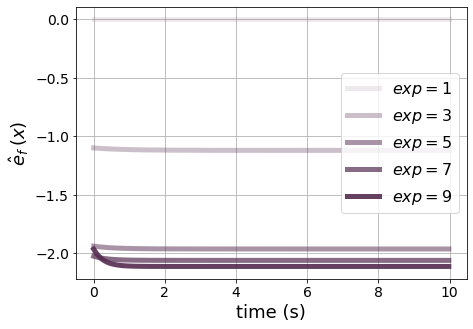

In [126]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 2 == 0:
        V = np.array(a_h_lst)[exp,start:]
        ax.plot(t_lns[start:], V , color = (0.329, 0.168, 0.313), alpha = 0.1 * (exp + 1), linewidth = 5)
        #print(exp)
        
ax.grid(True)
#ax.set_title('Evolution of estimator $e_f$', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$\hat{e}_f\:(x)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-0.003 , -0.0025, -0.002 , -0.0015, -0.001 , -0.0005,  0.    ,
         0.0005,  0.001 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

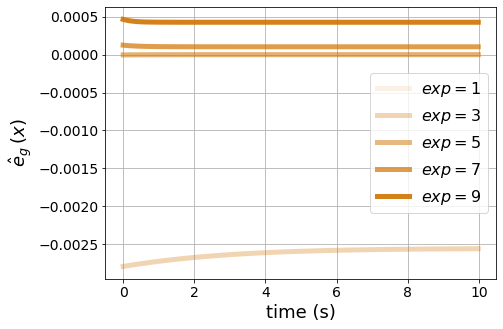

In [127]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 2 == 0:
        V = np.array(b_h_lst)[exp,start:]
        ax.plot(t_lns[start:], V, color = (0.819, 0.450, 0), alpha = 0.1 * (exp + 1), linewidth = 5 )
        #print(exp) 
        
ax.grid(True)
#ax.set_title('Evolution of estimator $e_g$', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$\hat{e}_g\:(x)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([35., 36., 37., 38., 39., 40., 41., 42., 43., 44.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

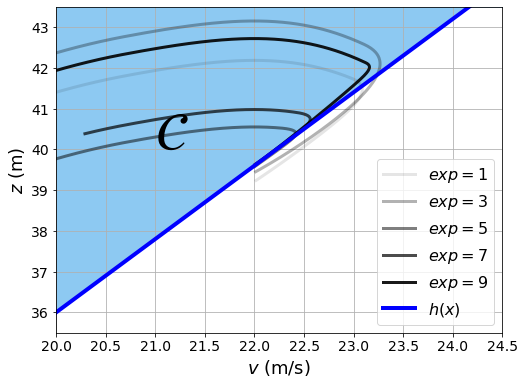

In [18]:
f,ax = plt.subplots(1,1,figsize = (8,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 9

#h_perf = np.array(B_perf_lst)[exp,start:]

for exp in range(10):
    if exp % 2 == 0:
        z = np.array(x_lst)[exp,start:,2]# np.array(B_lst)[exp,start:]
        v = np.array(x_lst)[exp,start:,1]
        ax.plot(v, z, 'black', alpha = 0.1 * (exp + 1), linewidth = 3)
        

        
        
ax.grid(True)
#ax.set_title('Safe distance performance vs velocity. $z \geq T_h v$', fontsize= 18)
#ax.legend(['estimated','real'],fontsize= 16) 
ax.set_ylabel('$z$ (m)', fontsize= 18)
ax.set_xlabel('$v$ (m/s)', fontsize= 18)

v_min = 20
v_max = 24.5
z_min = 35.5
z_max = 43.5

v_span = np.linspace(v_min, v_max, 50)
ax.plot(v_span, v_span*Th, 'blue',linewidth = 4 )


ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','$h(x)$'],fontsize= 16) 
plt.gca().fill_between(v_span, v_span*Th, z_max, v_span > 0, color = (0.552, 0.788, 0.949))
ax.set_ylim(z_min, z_max)
ax.set_xlim(v_min, v_max)

ax.text(21,40,'$\mathcal{C}$', fontsize=54)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0

for exp in range(10):
    if exp % 3 == 0:
        h_ = np.array(B_perf_lst)[exp,start:]
        ax.plot(t_lns[start:], h )
        #print(exp)
        
ax.grid(True)
ax.set_title('Barrier function evolution in multiple experiences', fontsize= 18)
ax.legend(['exp 1','exp 4','exp 7','exp 10'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$V(x, u)$', fontsize= 18)

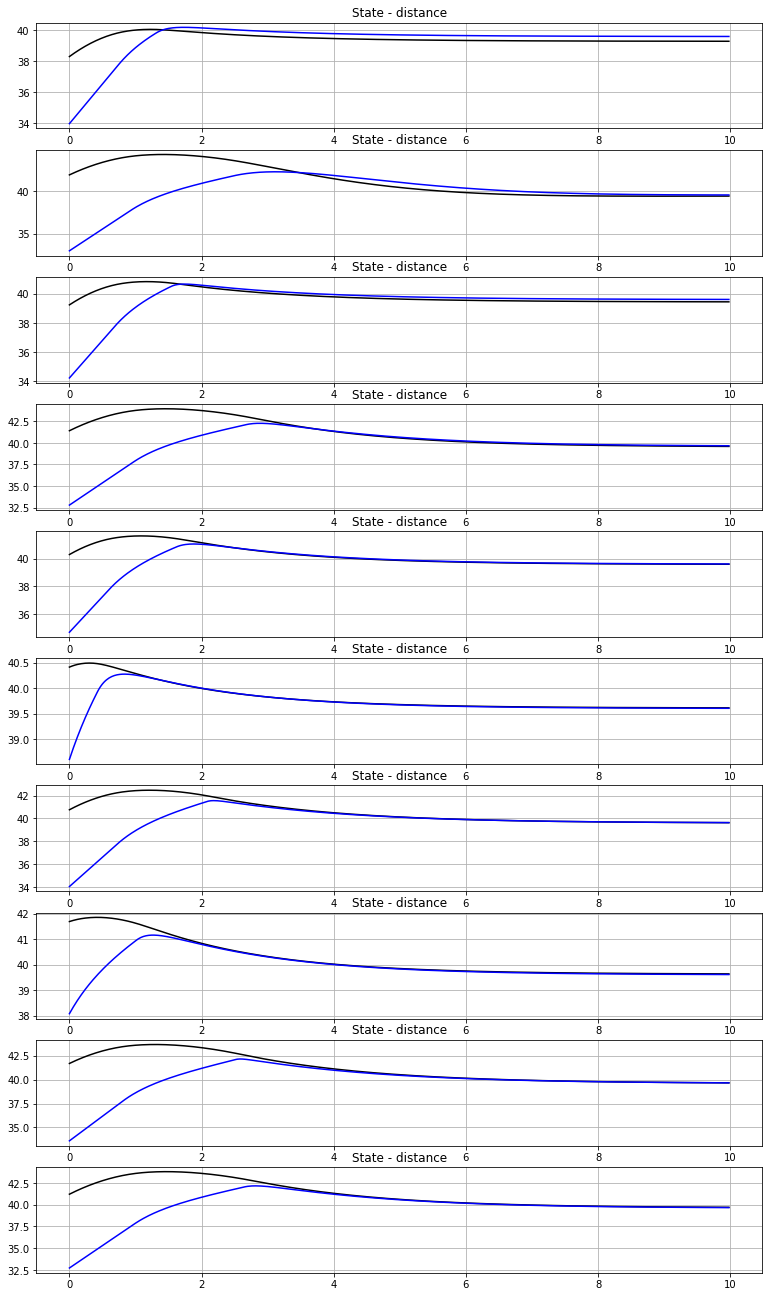

In [73]:
f,ax = plt.subplots(10,1,figsize = (13,23))
t_lns = np.arange(0, 10, dt)

for exp in range(10):
    ax[exp].plot(t_lns, np.array(x_lst)[exp,:,2],'black')
    ax[exp].grid(True)
    ax[exp].set_title('State - distance')

    ax[exp].plot(t_lns, Th*np.array(x_lst)[exp,:,1], 'blue')

### First time